# Quickstart to manipulate a GPS track

### Or how to load, plot, use operators to compute new features, summarize, split and segment on a GPS track

Le but de ce quickstart est de montrer quelques commandes de base de la librairie tracklib. Les données d'une trace GPS qui représente un entrainement de course à pied sur une piste d'athletisme. Nous verrons donc comment charger les données, la représenter avec des indicateurs de base (vitesse, abscisse curviligne, etc.) afin d'y observer visuellement des phénomènes. Enfin nous verrons comment segmenter la trace suivant un changement de vitesse détecté.

## Import de la librairie tracklib

<span style="color:blue">This task is only useful for the online notebook</span>

In [1]:
import matplotlib.pyplot as plt

import os
import sys

# Import de tracklib
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Read GPS data, transform coordinates and print summary

In [2]:
from tracklib.core.ObsTime import ObsTime
from tracklib.io.TrackReader import TrackReader

# ---------------------------------------------------
# Lecture des donnees
# ---------------------------------------------------
ObsTime.setReadFormat("4Y-2M-2DT2h:2m:2sZ")

tracks = TrackReader.readFromGpx('../../../data/gpx/activity_5807084803.gpx')
trace = tracks.getTrack(0)

# Transformation GEO coordinates to ENU
trace.toENUCoords()

# Summary
trace.summary()

-------------------------------------
GPS track #activity_5807084803 of user 0:
-------------------------------------
  Nb of pt(s):   190
  Ref sys id   : ENU
  Starting at  : 11/11/2020 15:39:54
  Ending at    : 11/11/2020 15:52:00
  Duration     : 726.000 s
  Length       : 2412.144 m
-------------------------------------



## Display GPS data

* Figure 1: in a cartesian reference frame 
* Figure 2: in a circular reference frame

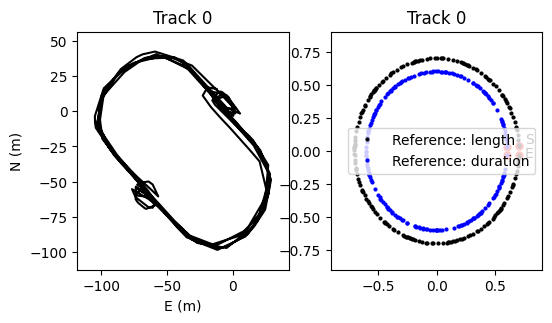

In [3]:
plt.figure(figsize=(6, 2))
plt.subplots_adjust(top=1.3, wspace=0.2, hspace=0.2)

# GPS track in a cartesian coordinate system
ax1 = plt.subplot2grid((1, 2), (0, 0))
trace.plot(type='LINE', append=ax1)

#
ax2 = plt.subplot2grid((1, 2), (0, 1))
trace.plot(type='CIRCULAR', append=ax2)

plt.show()

## Compute local speed

La méthode estimate_speed de l'objet track, calcule la vitesse locale en chaque point et stocke le résultat dans une AF "speed".

La vitesse locale sur le premier (resp dernier) point est égale à la vitesse au premier (resp avant dernier) point. Pour les autres points, la vitesse est calculée suivant le point précédent et le suivant:

speed(i) = distance (point(i+1), point(i-1)) / temps écoulé entre point(i-1) et point (i+1)

In [4]:
# Compute local speed
trace.estimate_speed()
print ('')

# Get all speed values
SPEEDS = trace.getAnalyticalFeature('speed')
# Display the top ten speeds
print (SPEEDS[0:10])


[4.55221497831179, 6.255327113366183, 5.896832339965242, 4.978192041525976, 5.334848802884135, 5.503904742096748, 4.541114070830664, 4.5655781449843715, 4.272215133699211, 4.3784508497879155]


## Different plots of speed observations

* Figure 1: whisker plot for each speed values
* Figure 2: GPS data, color depends on speed
* Figure 3: speed profil along the curvilinear abscissa

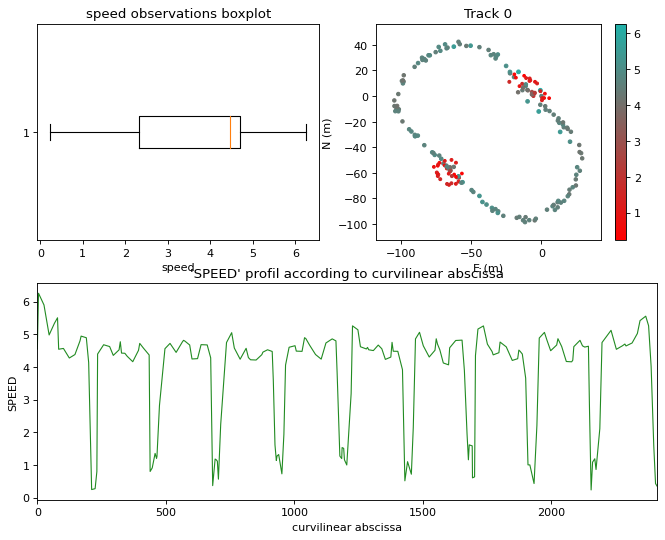

In [5]:
from tracklib.plot.Plot import Plot

plot = Plot(trace)

plt.figure(figsize=(10, 5), dpi=80)
plt.subplots_adjust(top=1.3, wspace=0.2, hspace=0.2)

# 
ax1 = plt.subplot2grid((2, 2), (0, 0))
plot.plotAnalyticalFeature('speed', 'BOXPLOT', append=ax1) 

# Display the GPS data, color depends on speed
ax2 = plt.subplot2grid((2, 2), (0, 1))
plot.plot(type='POINT', af_name='speed', append=ax2)

# Display the speed profil along the curvilinear abscissa
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
plot.plotProfil('SPATIAL_SPEED_PROFIL', append=ax3)

## Summarize analytical features and plot it in images

In tracklib library, it is possible to summarize into a regular grid features (quantitatives measures). For example, the average of speed, most dominant direction and the minimum of acceleration are computed per 3 by 3 meter cells.

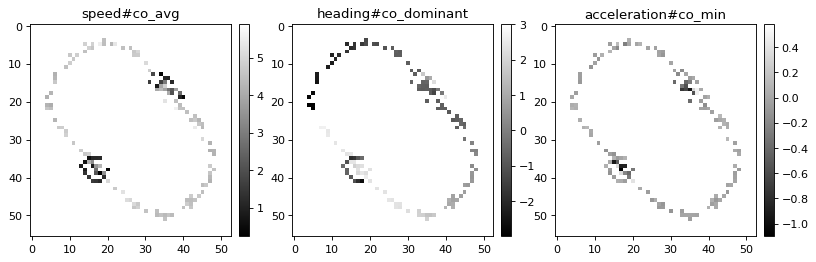

In [6]:
from tracklib.core.TrackCollection import TrackCollection
from tracklib.algo import (Summarising, Analytics) 

collection = TrackCollection([trace])

af_algos = [Analytics.speed, Analytics.heading, Analytics.acceleration]
cell_operators = [Summarising.co_avg, Summarising.co_dominant, Summarising.co_min]
marge = 0.1
raster = Summarising.summarize(collection, af_algos, cell_operators, (3,3), marge)

plt.figure(figsize=(12, 10), dpi=80)
plt.subplots_adjust(top=1.3, wspace=0.2, hspace=0.2)

ax1 = plt.subplot2grid((1, 3), (0, 0))
raster.plot('speed#co_avg', append=ax1)

ax2 = plt.subplot2grid((1, 3), (0, 1))
raster.plot('heading#co_dominant', append=ax2)

ax3 = plt.subplot2grid((1, 3), (0, 2))
raster.plot('acceleration#co_min', append=ax3)


## Compute speed change

Speed change is calculated as the absolute of the difference of speed between two consecutive points:

1. $dv_i = v_i - v_{i-1}$

   we compute $dv$ by using the differentiator operator
   

2. $absdv_i = |dv_i|$

   follow up rectifier operator to have the absolute value of the difference

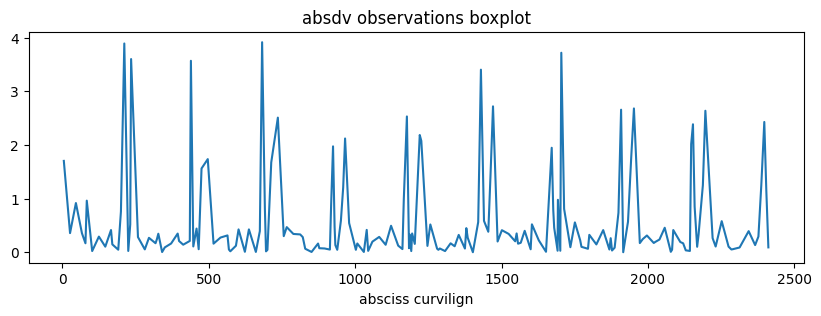

In [7]:
from tracklib.core.Operator import Operator

trace.operate(Operator.DIFFERENTIATOR, "speed", "dv")
trace.operate(Operator.RECTIFIER, "dv", "absdv")

# Speed change according to the curvilinear abscissa
plot = Plot(trace)
plot.plotAnalyticalFeature("absdv", "PLOT")

## Segmentation

Once the speed change marker is calculed, we can split the track on a collection of tracks. The marker is called here $speed_decoup$. We cut the track when the speed change is under the threshold 1.5 meter per second. If the track splitted have less 50 points, we don't keep it.

Next, we show the tracks segmented and interpolated with the spline method. Some indicators on the speed are calculated at the same time. 

Rep 1 :  vmoy =  16.85 km/h   vmax =  19.32  km/h   vc =  16.8 km/h
Rep 2 :  vmoy =  16.0 km/h   vmax =  17.04  km/h   vc =  16.15 km/h
Rep 3 :  vmoy =  16.34 km/h   vmax =  17.48  km/h   vc =  16.55 km/h
Rep 4 :  vmoy =  15.68 km/h   vmax =  16.56  km/h   vc =  15.9 km/h
Rep 5 :  vmoy =  16.26 km/h   vmax =  17.9  km/h   vc =  16.76 km/h
Rep 6 :  vmoy =  15.83 km/h   vmax =  17.11  km/h   vc =  16.32 km/h
Rep 7 :  vmoy =  15.99 km/h   vmax =  18.05  km/h   vc =  16.27 km/h
Rep 8 :  vmoy =  16.09 km/h   vmax =  18.84  km/h   vc =  16.42 km/h
Rep 9 :  vmoy =  16.32 km/h   vmax =  17.91  km/h   vc =  16.36 km/h
Rep 10 :  vmoy =  17.4 km/h   vmax =  20.2  km/h   vc =  18.17 km/h


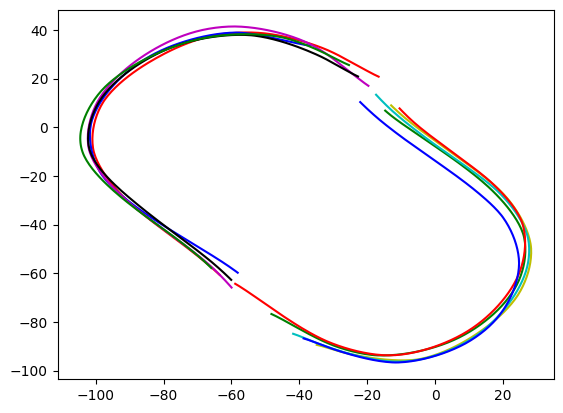

In [8]:
import tracklib.algo.Segmentation as segmentation
import tracklib.algo.Interpolation as interp

#  Segmentation
segmentation.segmentation(trace, ["absdv"], "speed_decoup", [1.5])

# ------------------------------------------------------------------
# + récupération d'un sous-ensemble de traces
# + interpolation/lissage + ré-estimation des vitesses...
# ------------------------------------------------------------------
segmentedTracks = segmentation.split(trace, "speed_decoup", limit=50)

# Affichage
COLORS = ['k-','r-','g-','b-','y-','m-','c-']

count = 0
interp.SPLINE_PENALIZATION = 1e-2
for track in segmentedTracks:
    count += 1
    track.resample(1, interp.ALGO_THIN_SPLINES, interp.MODE_SPATIAL)
    track.estimate_speed()
    diff = track.getLastObs().timestamp - track.getFirstObs().timestamp
    v = round(track.length()/diff*3.6,2)
    vm = round(track.operate(Operator.MAX, "speed")*3.6,2)
    vc = round(100/(track.getObs(150).timestamp-track.getObs(50).timestamp)*3.6,2)
    print("Rep", count, ":  vmoy = ", v, "km/h   vmax = ", vm, " km/h   vc = ", vc, "km/h")
    plt.plot(track.getX(), track.getY(), COLORS[count%7])

plt.show()